
# 1 Introduction and Overview of Inference Deployment


This chapter mainly introduces the high-performance inference method, service deployment method and end-side deployment method of the PP-OCRv2 system. Through the study of this chapter, you can learn:

* Choose the appropriate predictive deployment method according to different scenarios
* Inference methods of PP-OCRv2 series models in different scenarios
* Inference deployment development methods of Paddle Inference, Paddle Serving, and Paddle Lite

## 1.1 Introduction

In the previous chapters, we obtained the trained model through the method of model training. When using it to predict, we first need to define the model, then load the trained model, and then preprocess the data Send it to the network for prediction and post-processing, and get the final result. Using this method to make predictions is convenient for debugging, but the prediction efficiency is relatively low.

In view of the above problems, for the trained model, there are generally the following two offline prediction methods.

1. Inference based on the training engine, that is, using the same set of engine as the training, it is convenient for debugging, which is convenient for us to quickly locate the problem and verify the correctness. Mostly Python language.
2. Based on the prediction engine inference, the trained model is transformed, and the parts that are not related to the inference are removed. Using this method can speed up the prediction. Most of them are Python language or C++.

The specific differences between the two are shown below.
<center>

|      | Inference based on training engine    | Inference based on prediction engine    |
|:------:|:------|:------|
| Features   |1. Use the same set of engine as training</br>2. The network model needs to be defined when inferencing</br>3. Not suitable for system integration| 1. The model needs to be converted, and the parts that are not related to inference are removed</br>2. * *There is no need to define a network model when inferencing**</br>3. Suitable for system integration|
| Programming language | More as Python                                     | Python or C++                     |
| Prediction step | 1. Define the network structure on the Python side</br>2. Prepare the input data</br>3. Load the training model</br>4. Perform prediction| 1. Prepare the input data</br>2. Load the model structure and model Parameters</br>3. Perform prediction|

</center>

In actual offline prediction deployment, it is more recommended to perform inference based on the prediction engine.

From the perspective of application scenarios, the flying paddle provides the following inference deployment solutions for different application scenarios.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/d95a9b662f944af589cf3934b7012f54bfb1ef610c0447568712618fdb6216a2"  width = "1200" />
</div>
<center>Figure 1: Different deployment options for paddles</center>

Specifically, PaddleOCR provides three predictive deployment solutions for different application scenarios.

* Inference offline prediction. This method is mainly used in scenarios where the timeliness of the prediction response is not high, especially in scenes that require a large number of picture predictions. Such as document digitization, advertising information extraction, etc. Although the inference request cannot be responded to in time, there is no network delay, the calculation efficiency is relatively high, and the data security is high.
* Serving service deployment, this method is mainly used in scenarios that require high timeliness of predictive response, such as the API interface of commercial OCR, real-time photo translation, and topic shooting. Although this method can respond to inference demand in a timely manner, the network is time-consuming and expensive, GPU utilization is often low, and there are data security risks.
* Lite end-side deployment, this method mainly hopes to deploy the model to end-side devices such as mobile phones and robots, mainly considering the convenience of deployment and data security, such as ID card recognition in mobile APP, bank card recognition, and instrument monitoring in industrial application scenarios Recognition etc. This method is more sensitive to the size of the OCR model. Although there is no network delay and data security is high, the prediction efficiency is not high due to the limitation of computing power.

Based on PP-OCRv2, this chapter introduces the process of text detection, recognition, and system series prediction, inference and deployment.

## 1.2 Environmental preparation

To experience the content of this chapter, you need to download the PaddleOCR code first and install related dependencies. The specific commands are as follows.

In [1]:
import os

os.chdir("/home/aistudio")
# Download code
!git clone https://gitee.com/paddlepaddle/PaddleOCR.git
os.chdir("/home/aistudio/PaddleOCR")
# Install and run the required whl package
!pip install -U pip
!pip install -r requirements.txt
# This library is needed in VQA tasks
!pip install paddlenlp==2.2.1

# Import some libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 2335, done.
remote: Counting objects: 100% (2335/2335), done.
remote: Compressing objects: 100% (937/937), done.
remote: Total 27956 (delta 1569), reused 2078 (delta 1382), pack-reused 25621
Receiving objects: 100% (27956/27956), 245.96 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (19430/19430), done.
Checking connectivity... done.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 1.7MB 17.9MB/s eta 0:00:01
  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 1.1 MB 27.3 MB/s            
     |████████████████████████████████| 13.3 MB 74.2 MB/s            
     |████████████████████████████████| 948 kB 53.5 MB/s            
     |████████████████████████████████| 603 kB 55.1 MB/s            
     |██████████████████████


# 2 Python Inference Based on Paddle Inference

## 2.1 Introduction

In the project, the inference performance of the model directly affects the cost of the project, so we hope that a model of a trained model can have a faster inference speed. The prediction is directly based on the training engine, and the model contains operators related to training, so **the efficiency is generally low**; and the model needs to be defined, which is **difficult to decouple from the training code**. Paddle Inference came into being. It is the native inference library of Flying Paddle, which acts on the server and the cloud to provide high-performance inference capabilities. Since the ability is directly based on the training operator of the flying paddle, Paddle Inference can universally support all models trained by the flying paddle.

Considering that everyone’s usage scenarios are very different, Paddle Inference has carried out in-depth adaptation and optimization for different platforms and different application scenarios, achieving high throughput and low latency, ensuring that the flying paddle model is ready to use on the server side, and is fast deploy.

This chapter mainly introduces the prediction inference process of **PP-OCRv2** based on Paddle Inference. For more introduction about Paddle Inference, please refer to: [Paddle Inference Introduction](https://paddleinference.paddlepaddle.org.cn/product_introduction/inference_intro.html).

When performing model inference based on Paddle Inference, there are generally the following steps.
<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/18090cbc0733401caeb868f7bf7759436771ba71bce444a8a4ff5dbc5eece03c"  width = "600" />
</div>
<center>Figure 2: Paddle Inference process</center>

The PP-OCRv2 system includes three models: text detection, direction classifier, and text recognition. The following describes the inference process of these three models based on Paddle Inference.


## 2.2 PP-OCRv2 Text Detection Model Inference

In PaddleOCR, when inference is based on the text detection model, the parameter `image_dir` specifies the path of a single image or image collection, and the parameter `det_model_dir` specifies the path of the detected `inference` model.

The following is the latest ultra-lightweight text detection model inference actual combat. For more models and usage methods, please refer to [Text Detection Prediction Tutorial](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/inference_ppocr.md).

For more introduction to the hyperparameters of other algorithms, please refer to [PaddleOCR Inference related parameters introduction](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/inference.md#%E5%85%AD%E5%8F%82%E6%95%B0%E8%A7%A3%E9%87%8A).


### 2.2.1 Prepare Data and Environment

At the very beginning, Paddle and the corresponding dependencies have been installed, and the environment here is ready.

The test sample data is under the `doc/imgs` folder, and part of the data is shown below.

00006737.jpg  00056221.jpg  00111002.jpg  1.jpg		japan_1.jpg
00009282.jpg  00057937.jpg  00207393.jpg  french_0.jpg	japan_2.jpg
00015504.jpg  00059985.jpg  11.jpg	  ger_1.jpg	korean_1.jpg
00018069.jpg  00077949.jpg  12.jpg	  ger_2.jpg	model_prod_flow_ch.png


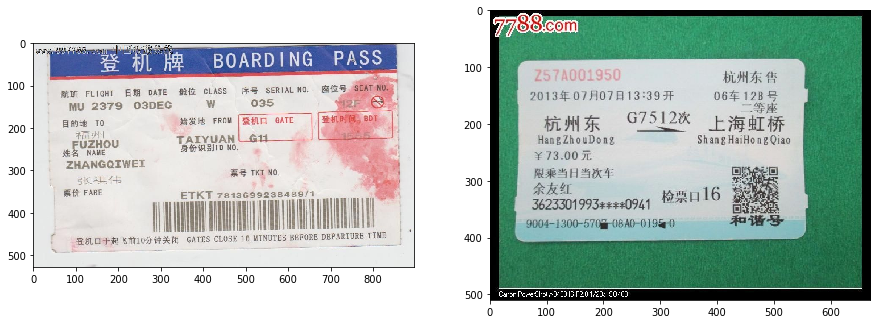

In [2]:
# Switch directory
os.chdir("/home/aistudio/PaddleOCR")

# View data
!ls doc/imgs/

# Choose 2 images to visualize
img1 = cv2.imread("doc/imgs/00006737.jpg")
img2 = cv2.imread("doc/imgs/00056221.jpg")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(img2[:,:,::-1])
plt.show()

### 2.2.2 Prepare the inference model

Download the inference model, unzip it, and place it under the `inference` directory.

In [3]:
# Download model
!mkdir inference
!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar
!tree -h inference/ch_PP-OCRv2_det_infer

--2021-12-25 14:55:13--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190272 (3.0M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_infer.tar’

ch_PP-OCRv2_det_inf 100%[===================>]   3.04M  --.-KB/s    in 0.07s   

2021-12-25 14:55:13 (42.2 MB/s) - ‘ch_PP-OCRv2_det_infer.tar’ saved [3190272/3190272]

inference/ch_PP-OCRv2_det_infer
├── [2.2M]  inference.pdiparams
├── [ 23K]  inference.pdiparams.info
└── [845K]  inference.pdmodel

0 directories, 3 files


* If you want to export the model you have trained and deploy it using Paddle Inference, you can use the following command to convert the pre-trained model into an inference model using dynamic and static methods.

In [4]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/export_model.py
# Download the pre-trained model
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_distill_train.tar && tar -xf ch_PP-OCRv2_det_distill_train.tar && rm ch_PP-OCRv2_det_distill_train.tar
# Derive inference model
!python tools/export_model.py -c configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml \
    -o Global.pretrained_model="ch_PP-OCRv2_det_distill_train/best_accuracy" \
    Global.save_inference_dir="./my_model"
# The PP-OCRv2 detection model contains 3 sub-networks: teacher, student, and student 2. Therefore, when exporting, it contains 3 sub-files. In actual inference, one of the student networks can be used for inference.
!tree -h my_model

--2021-12-25 14:55:21--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_distill_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63830016 (61M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_distill_train.tar’

ch_PP-OCRv2_det_dis 100%[===================>]  60.87M  81.4MB/s    in 0.7s    

2021-12-25 14:55:22 (81.4 MB/s) - ‘ch_PP-OCRv2_det_distill_train.tar’ saved [63830016/63830016]

W1225 14:55:24.746377  1078 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1225 14:55:24.749907  1078 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[2021/12/25 14:55:30] root INFO: load pretrain successful from ch_PP-OCRv2_det_distill_train/best_accuracy
[2021/12/25 14:55:31] root INFO: inference model is saved t

### 2.2.3 A Preliminary Study of Text Detection Function

Let's first take a look at the predicted results of the loading inference model.

[2021/12/25 14:56:01] root INFO: 00018069.jpg	[[[378, 249], [411, 252], [409, 266], [377, 265]], [[300, 250], [344, 250], [344, 265], [300, 265]], [[233, 250], [268, 250], [268, 265], [233, 265]], [[101, 249], [184, 249], [184, 266], [101, 266]], [[25, 250], [52, 250], [52, 266], [25, 266]], [[375, 233], [409, 233], [409, 247], [375, 247]], [[285, 233], [362, 233], [362, 247], [285, 247]], [[234, 233], [269, 233], [269, 247], [234, 247]], [[24, 234], [53, 234], [53, 247], [24, 247]], [[101, 230], [184, 230], [184, 248], [101, 248]], [[23, 214], [51, 214], [51, 229], [23, 229]], [[378, 213], [410, 213], [410, 228], [378, 228]], [[295, 211], [348, 214], [347, 229], [294, 226]], [[231, 213], [268, 213], [268, 228], [231, 228]], [[100, 212], [185, 212], [185, 229], [100, 229]], [[309, 195], [338, 195], [338, 209], [309, 209]], [[231, 194], [268, 194], [268, 209], [231, 209]], [[23, 194], [51, 194], [51, 210], [23, 210]], [[378, 193], [409, 193], [409, 209], [378, 209]], [[99, 193], [188, 1

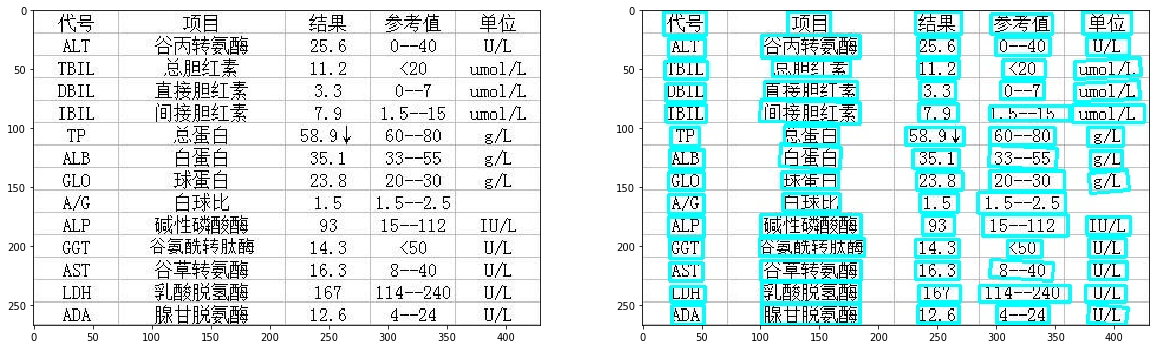

In [5]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_det.py
# prediction
!python tools/infer/predict_det.py --image_dir="./doc/imgs/00018069.jpg" --det_model_dir="./inference/ch_PP-OCRv2_det_infer" --use_gpu=False

# Read the image and display it, display the result
plt.figure(figsize=(20, 8))
img_ori = cv2.imread("./doc/imgs/00018069.jpg")
img_out = cv2.imread("./inference_results/det_res_00018069.jpg")
plt.subplot(1, 2, 1)
plt.imshow(img_ori[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(img_out[:,:,::-1])
plt.show()


So how does it work? The following is a detailed explanation of the inference model loading and inference code of PP-OCRv2.

First, you need to define the parameter settings as shown below. For more parameter introduction, please refer to: [PaddleOCR inference process parameter introduction](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/doc/doc_ch/inference.md#%E5%85%AD%E5%8F%82%E6%95%B0%E8%A7%A3%E9%87%8A).

In [6]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/utility.py
import argparse
import os
import sys
import cv2
import numpy as np
import paddle
from PIL import Image, ImageDraw, ImageFont
import math
from paddle import inference
import time
from ppocr.utils.logging import get_logger


def str2bool(v):
    return v.lower() in ("true", "t", "1")


def init_args():
    parser = argparse.ArgumentParser()
    # params for prediction engine
    parser.add_argument("--use_gpu", type=str2bool, default=True)
    parser.add_argument("--ir_optim", type=str2bool, default=True)
    parser.add_argument("--use_tensorrt", type=str2bool, default=False)
    parser.add_argument("--min_subgraph_size", type=int, default=15)
    parser.add_argument("--precision", type=str, default="fp32")
    parser.add_argument("--gpu_mem", type=int, default=500)

    # params for text detector
    parser.add_argument("--image_dir", type=str)
    parser.add_argument("--det_algorithm", type=str, default='DB')
    parser.add_argument("--det_model_dir", type=str)
    parser.add_argument("--det_limit_side_len", type=float, default=960)
    parser.add_argument("--det_limit_type", type=str, default='max')

    # DB parmas
    parser.add_argument("--det_db_thresh", type=float, default=0.3)
    parser.add_argument("--det_db_box_thresh", type=float, default=0.6)
    parser.add_argument("--det_db_unclip_ratio", type=float, default=1.5)
    parser.add_argument("--max_batch_size", type=int, default=10)
    parser.add_argument("--use_dilation", type=str2bool, default=False)
    parser.add_argument("--det_db_score_mode", type=str, default="fast")
    # EAST parmas
    parser.add_argument("--det_east_score_thresh", type=float, default=0.8)
    parser.add_argument("--det_east_cover_thresh", type=float, default=0.1)
    parser.add_argument("--det_east_nms_thresh", type=float, default=0.2)

    # SAST parmas
    parser.add_argument("--det_sast_score_thresh", type=float, default=0.5)
    parser.add_argument("--det_sast_nms_thresh", type=float, default=0.2)
    parser.add_argument("--det_sast_polygon", type=str2bool, default=False)

    # PSE parmas
    parser.add_argument("--det_pse_thresh", type=float, default=0)
    parser.add_argument("--det_pse_box_thresh", type=float, default=0.85)
    parser.add_argument("--det_pse_min_area", type=float, default=16)
    parser.add_argument("--det_pse_box_type", type=str, default='box')
    parser.add_argument("--det_pse_scale", type=int, default=1)

    # params for text recognizer
    parser.add_argument("--rec_algorithm", type=str, default='CRNN')
    parser.add_argument("--rec_model_dir", type=str)
    parser.add_argument("--rec_image_shape", type=str, default="3, 32, 320")
    parser.add_argument("--rec_batch_num", type=int, default=6)
    parser.add_argument("--max_text_length", type=int, default=25)
    parser.add_argument(
        "--rec_char_dict_path",
        type=str,
        default="./ppocr/utils/ppocr_keys_v1.txt")
    parser.add_argument("--use_space_char", type=str2bool, default=True)
    parser.add_argument(
        "--vis_font_path", type=str, default="./doc/fonts/simfang.ttf")
    parser.add_argument("--drop_score", type=float, default=0.5)

    # params for e2e
    parser.add_argument("--e2e_algorithm", type=str, default='PGNet')
    parser.add_argument("--e2e_model_dir", type=str)
    parser.add_argument("--e2e_limit_side_len", type=float, default=768)
    parser.add_argument("--e2e_limit_type", type=str, default='max')

    # PGNet parmas
    parser.add_argument("--e2e_pgnet_score_thresh", type=float, default=0.5)
    parser.add_argument(
        "--e2e_char_dict_path", type=str, default="./ppocr/utils/ic15_dict.txt")
    parser.add_argument("--e2e_pgnet_valid_set", type=str, default='totaltext')
    parser.add_argument("--e2e_pgnet_mode", type=str, default='fast')

    # params for text classifier
    parser.add_argument("--use_angle_cls", type=str2bool, default=False)
    parser.add_argument("--cls_model_dir", type=str)
    parser.add_argument("--cls_image_shape", type=str, default="3, 48, 192")
    parser.add_argument("--label_list", type=list, default=['0', '180'])
    parser.add_argument("--cls_batch_num", type=int, default=6)
    parser.add_argument("--cls_thresh", type=float, default=0.9)

    parser.add_argument("--enable_mkldnn", type=str2bool, default=False)
    parser.add_argument("--cpu_threads", type=int, default=10)
    parser.add_argument("--use_pdserving", type=str2bool, default=False)
    parser.add_argument("--warmup", type=str2bool, default=False)

    #
    parser.add_argument(
        "--draw_img_save_dir", type=str, default="./inference_results")
    parser.add_argument("--save_crop_res", type=str2bool, default=False)
    parser.add_argument("--crop_res_save_dir", type=str, default="./output")

    # multi-process
    parser.add_argument("--use_mp", type=str2bool, default=False)
    parser.add_argument("--total_process_num", type=int, default=1)
    parser.add_argument("--process_id", type=int, default=0)

    parser.add_argument("--benchmark", type=str2bool, default=False)
    parser.add_argument("--save_log_path", type=str, default="./log_output/")

    parser.add_argument("--show_log", type=str2bool, default=True)
    parser.add_argument("--use_onnx", type=str2bool, default=False)
    # It should be noted here that this is added because if you parse directly in the notebook, sys.argv will add the following content at the back, causing the parsing to fail
    # '-f', '/home/aistudio/.local/share/jupyter/runtime/kernel-e1221262-c656-4129-896f-1b197b6b782c.json'
    parser.add_argument("-f", type=str, default=None)
    return parser


def parse_args():
    parser = init_args()
    return parser.parse_args()

Let's take a look at the specific code for text detection.

[2021/12/25 15:10:56] root INFO: 00018069.jpg	[[[378, 249], [411, 252], [409, 266], [377, 265]], [[300, 250], [344, 250], [344, 265], [300, 265]], [[233, 250], [268, 250], [268, 265], [233, 265]], [[101, 249], [184, 249], [184, 266], [101, 266]], [[25, 250], [52, 250], [52, 266], [25, 266]], [[375, 233], [409, 233], [409, 247], [375, 247]], [[285, 233], [362, 233], [362, 247], [285, 247]], [[234, 233], [269, 233], [269, 247], [234, 247]], [[24, 234], [53, 234], [53, 247], [24, 247]], [[101, 230], [184, 230], [184, 248], [101, 248]], [[23, 214], [51, 214], [51, 229], [23, 229]], [[378, 213], [410, 213], [410, 228], [378, 228]], [[295, 211], [348, 214], [347, 229], [294, 226]], [[231, 213], [268, 213], [268, 228], [231, 228]], [[100, 212], [185, 212], [185, 229], [100, 229]], [[309, 195], [338, 195], [338, 209], [309, 209]], [[231, 194], [268, 194], [268, 209], [231, 209]], [[23, 194], [51, 194], [51, 210], [23, 210]], [[378, 193], [409, 193], [409, 209], [378, 209]], [[99, 193], [188, 1

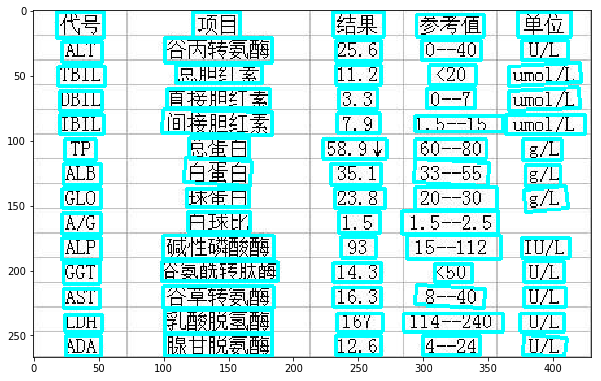

In [8]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_det.py
import os
import sys
import cv2
import numpy as np
import time

import tools.infer.utility as utility
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read_gif
from ppocr.data import create_operators, transform
from ppocr.postprocess import build_post_process
import json
logger = get_logger()

# Text detection class
class TextDetector(object):
    def __init__(self, args):
        self.args = args
        self.det_algorithm = args.det_algorithm
        pre_process_list = [{
            'DetResizeForTest': {
                'limit_side_len': args.det_limit_side_len,
                'limit_type': args.det_limit_type,
            }
        }, {
            'NormalizeImage': {
                'std': [0.229, 0.224, 0.225],
                'mean': [0.485, 0.456, 0.406],
                'scale': '1./255.',
                'order': 'hwc'
            }
        }, {
            'ToCHWImage': None
        }, {
            'KeepKeys': {
                'keep_keys': ['image', 'shape']
            }
        }]
        postprocess_params = {}
        if self.det_algorithm == "DB":
            postprocess_params['name'] = 'DBPostProcess'
            postprocess_params["thresh"] = args.det_db_thresh
            postprocess_params["box_thresh"] = args.det_db_box_thresh
            postprocess_params["max_candidates"] = 1000
            postprocess_params["unclip_ratio"] = args.det_db_unclip_ratio
            postprocess_params["use_dilation"] = args.use_dilation
            postprocess_params["score_mode"] = args.det_db_score_mode
        else:
            logger.info("unknown det_algorithm:{}".format(self.det_algorithm))
            sys.exit(0)
        # Initialize the prediction engine
        self.predictor, self.input_tensor, self.output_tensors, self.config = utility.create_predictor(
            args, 'det', logger)
        # Construct preprocessing operator
        self.preprocess_op = create_operators(pre_process_list)
        # Post-construction operator
        self.postprocess_op = build_post_process(postprocess_params)
        

    def order_points_clockwise(self, pts):
        """
        Refer: https://github.com/jrosebr1/imutils/blob/master/imutils/perspective.py
       Sort the detected points clockwise
        """
        xSorted = pts[np.argsort(pts[:, 0]), :]

        leftMost = xSorted[:2, :]
        rightMost = xSorted[2:, :]

        leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
        (tl, bl) = leftMost

        rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
        (tr, br) = rightMost

        rect = np.array([tl, tr, br, bl], dtype="float32")
        return rect

    def clip_det_res(self, points, img_height, img_width):
        # Limit the detection results according to the width and height to prevent exceeding the image boundary
        for pno in range(points.shape[0]):
            points[pno, 0] = int(min(max(points[pno, 0], 0), img_width - 1))
            points[pno, 1] = int(min(max(points[pno, 1], 0), img_height - 1))
        return points

    def filter_tag_det_res(self, dt_boxes, image_shape):
        # Remove test results smaller than a certain size
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = self.order_points_clockwise(box)
            box = self.clip_det_res(box, img_height, img_width)
            rect_width = int(np.linalg.norm(box[0] - box[1]))
            rect_height = int(np.linalg.norm(box[0] - box[3]))
            if rect_width <= 3 or rect_height <= 3:
                continue
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes

    def filter_tag_det_res_only_clip(self, dt_boxes, image_shape):
        # Limit only the boundary of the detection result
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = self.clip_det_res(box, img_height, img_width)
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes

    def __call__(self, img):
        ori_im = img.copy()
        data = {'image': img}

        st = time.time()
        
        # Data preprocessing
        data = transform(data, self.preprocess_op)
        img, shape_list = data
        if img is None:
            return None, 0
        # Extended bs dimension: CHW -> NCHW
        img = np.expand_dims(img, axis=0)
        shape_list = np.expand_dims(shape_list, axis=0)
        img = img.copy()
        # Copy the data to the prediction engine
        self.input_tensor.copy_from_cpu(img)
        # Automatic inference
        self.predictor.run()
        outputs = []
        # Copy the returned result from the prediction engine back to the CPU
        for output_tensor in self.output_tensors:
            output = output_tensor.copy_to_cpu()
            outputs.append(output)

        preds = {}
        if self.det_algorithm in ['DB', 'PSE']:
            preds['maps'] = outputs[0]
        else:
            raise NotImplementedError

        # Post-processing
        post_result = self.postprocess_op(preds, shape_list)
        dt_boxes = post_result[0]['points']
        dt_boxes = self.filter_tag_det_res(dt_boxes, ori_im.shape)
        
        et = time.time()
        return dt_boxes, et - st

# Setting parameters
args = parse_args()
args.det_model_dir = "./inference/ch_PP-OCRv2_det_infer"
args.image_dir = "./doc/imgs/00018069.jpg"

# Get a list of pictures
image_file_list = get_image_file_list(args.image_dir)
# Create a text detector object
text_detector = TextDetector(args)

count = 0
total_time = 0
draw_img_save = "./inference_results"

if not os.path.exists(draw_img_save):
    os.makedirs(draw_img_save)
save_results = []
for image_file in image_file_list:
    img = cv2.imread(image_file)
    if img is None:
        logger.info("error in loading image:{}".format(image_file))
        continue
    st = time.time()
    dt_boxes, _ = text_detector(img)
    elapse = time.time() - st
    if count > 0:
        total_time += elapse
    count += 1
    save_pred = os.path.basename(image_file) + "\t" + str(
        json.dumps(np.array(dt_boxes).astype(np.int32).tolist())) + "\n"
    save_results.append(save_pred)
    logger.info(save_pred)
    logger.info("The predict time of {}: {}".format(image_file, elapse))
    src_im = utility.draw_text_det_res(dt_boxes, image_file)
    img_name_pure = os.path.split(image_file)[-1]
    img_path = os.path.join(draw_img_save,
                            "det_res_{}".format(img_name_pure))
    cv2.imwrite(img_path, src_im)
    logger.info("The visualized image saved in {}".format(img_path))
    
    break

with open(os.path.join(draw_img_save, "det_results.txt"), 'w') as f:
    f.writelines(save_results)
    f.close()

plt.figure(figsize=(10, 10))
plt.imshow(src_im[:, :, ::-1])
plt.show()

The above completes the complete text detection process.

## 2.3 PP-OCRv2 - Directional Classifier Model Inference

Similarly, for the direction classifier model, we can also use the following commands to quickly experience its functions.

--2021-12-25 15:40:13--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1454080 (1.4M) [application/x-tar]
Saving to: ‘ch_ppocr_mobile_v2.0_cls_infer.tar’

ch_ppocr_mobile_v2. 100%[===================>]   1.39M  --.-KB/s    in 0.04s   

2021-12-25 15:40:13 (33.6 MB/s) - ‘ch_ppocr_mobile_v2.0_cls_infer.tar’ saved [1454080/1454080]

[2021/12/25 15:40:15] root INFO: Predicts of ./doc/imgs_words/ch/word_1.jpg:['0', 0.9998784]


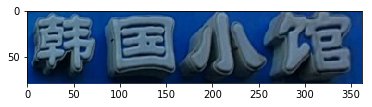

In [9]:
# Download model
!cd inference && wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O ch_ppocr_mobile_v2.0_cls_infer.tar && tar -xf ch_ppocr_mobile_v2.0_cls_infer.tar
# predict
!python tools/infer/predict_cls.py \
    --image_dir="./doc/imgs_words/ch/word_1.jpg" \
    --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer" \
    --use_gpu=False
# Drawing
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")
plt.imshow(img[:,:,::-1])
plt.show()

The direction of the picture is forward horizontal text, and the prediction result is correct.

Specifically, the specific implementation code of the direction classifier is as follows.

[2021/12/25 15:43:28] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:['0', 0.9999982]


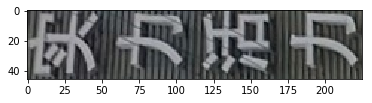

In [10]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_cls.py
import copy

# Class implemented by the direction classifier
class TextClassifier(object):
    def __init__(self, args):
        self.cls_image_shape = [int(v) for v in args.cls_image_shape.split(",")]
        self.cls_batch_num = args.cls_batch_num
        self.cls_thresh = args.cls_thresh
        postprocess_params = {
            'name': 'ClsPostProcess',
            "label_list": args.label_list,
        }
        # Post-processing operator
        self.postprocess_op = build_post_process(postprocess_params)
        # Initialize the prediction engine
        self.predictor, self.input_tensor, self.output_tensors, _ = \
            utility.create_predictor(args, 'cls', logger)

    # Resize and normalize the image
    def resize_norm_img(self, img):
        imgC, imgH, imgW = self.cls_image_shape
        h = img.shape[0]
        w = img.shape[1]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        if self.cls_image_shape[0] == 1:
            resized_image = resized_image / 255
            resized_image = resized_image[np.newaxis, :]
        else:
            resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

    def __call__(self, img_list):
        img_list = copy.deepcopy(img_list)
        img_num = len(img_list)
        # Record aspect ratio
        width_list = []
        for img in img_list:
            width_list.append(img.shape[1] / float(img.shape[0]))
        # Sort to speed up the subsequent pre-processing process
        indices = np.argsort(np.array(width_list))

        cls_res = [['', 0.0]] * img_num
        batch_num = self.cls_batch_num
        elapse = 0
        for beg_img_no in range(0, img_num, batch_num):
            end_img_no = min(img_num, beg_img_no + batch_num)
            norm_img_batch = []
            max_wh_ratio = 0
            starttime = time.time()
            # Preprocess data, group batch
            for ino in range(beg_img_no, end_img_no):
                h, w = img_list[indices[ino]].shape[0:2]
                wh_ratio = w * 1.0 / h
                max_wh_ratio = max(max_wh_ratio, wh_ratio)
            for ino in range(beg_img_no, end_img_no):
                norm_img = self.resize_norm_img(img_list[indices[ino]])
                norm_img = norm_img[np.newaxis, :]
                norm_img_batch.append(norm_img)
            norm_img_batch = np.concatenate(norm_img_batch)
            norm_img_batch = norm_img_batch.copy()
            # Copy the data to the prediction engine
            self.input_tensor.copy_from_cpu(norm_img_batch)
            # Automatic inference process
            self.predictor.run()
            # Copy the data back to the CPU
            prob_out = self.output_tensors[0].copy_to_cpu()
            # Post-processing
            cls_result = self.postprocess_op(prob_out)
            elapse += time.time() - starttime
            for rno in range(len(cls_result)):
                label, score = cls_result[rno]
                cls_res[indices[beg_img_no + rno]] = [label, score]
                if '180' in label and score > self.cls_thresh:
                    img_list[indices[beg_img_no + rno]] = cv2.rotate(
                        img_list[indices[beg_img_no + rno]], 1)
        return img_list, cls_res, elapse

args = parse_args()
args.cls_model_dir = "./inference/ch_ppocr_mobile_v2.0_cls_infer"
args.image_dir = "./doc/imgs_words/ch/word_4.jpg"

image_file_list = get_image_file_list(args.image_dir)
text_classifier = TextClassifier(args)
valid_image_file_list = []
img_list = []
for image_file in image_file_list:
    img = cv2.imread(image_file)
    # Rotate the image 180 degrees before prediction
    # img = cv2.rotate(img, cv2.ROTATE_180)
    if img is None:
        logger.info("error in loading image:{}".format(image_file))
        continue
    valid_image_file_list.append(image_file)
    img_list.append(img)
img_list, cls_res, predict_time = text_classifier(img_list)
for ino in range(len(img_list)):
    logger.info("Predicts of {}:{}".format(valid_image_file_list[ino],
                                            cls_res[ino]))

plt.imshow(img[:,:,::-1])
plt.show()

Here we can also rotate the image 180 degrees to see the classification effect of the direction classifier.

The above completes the inference process of the complete direction classifier.


## 2.4 PP-OCRv2 - Text Recognition Model Inference

For the text recognition model, we can also use the following commands to quickly experience its functions.

--2021-12-25 15:43:40--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8875520 (8.5M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_rec_infer.tar’

ch_PP-OCRv2_rec_inf 100%[===================>]   8.46M  --.-KB/s    in 0.1s    

2021-12-25 15:43:40 (64.5 MB/s) - ‘ch_PP-OCRv2_rec_infer.tar’ saved [8875520/8875520]

[2021/12/25 15:43:42] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:('实力活力', 0.9409585)


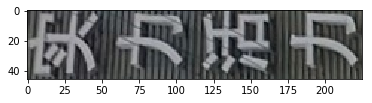

In [11]:
# Download model
!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar &&  tar -xf ch_PP-OCRv2_rec_infer.tar
# predict
!python tools/infer/predict_rec.py \
    --image_dir="./doc/imgs_words/ch/word_4.jpg" \
    --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer" \
    --use_gpu=False

# Read the image and display
img = cv2.imread("./doc/imgs_words/ch/word_4.jpg")
plt.imshow(img[:,:,::-1])
plt.show()

The specific code for text recognition is shown below.

In [12]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_rec.py
class TextRecognizer(object):
    def __init__(self, args):
        self.rec_image_shape = [int(v) for v in args.rec_image_shape.split(",")]
        self.rec_batch_num = args.rec_batch_num
        self.rec_algorithm = args.rec_algorithm
        postprocess_params = {
            'name': 'CTCLabelDecode',
            "character_dict_path": args.rec_char_dict_path,
            "use_space_char": args.use_space_char
        }
        # Initialize the prediction engine
        self.predictor, self.input_tensor, self.output_tensors, self.config = \
            utility.create_predictor(args, 'rec', logger)
        # Post-initialization process
        self.postprocess_op = build_post_process(postprocess_params)

    # Preprocessing core logic
    def resize_norm_img(self, img, max_wh_ratio):
        imgC, imgH, imgW = self.rec_image_shape
        assert imgC == img.shape[2]
        imgW = int((32 * max_wh_ratio))
        h, w = img.shape[:2]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        # [0, 255] -> [0, 1]
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        # [0, 1] -> [-0.5, 0.5]
        resized_image -= 0.5
        # [-0.5, 0.5] -> [-1, 1]
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

    # Process the image list
    def __call__(self, img_list):
        img_num = len(img_list)
        # Record aspect ratio
        width_list = []
        for img in img_list:
            width_list.append(img.shape[1] / float(img.shape[0]))
        # Sort, speed up the process
        indices = np.argsort(np.array(width_list))
        rec_res = [['', 0.0]] * img_num
        batch_num = self.rec_batch_num
        st = time.time()
        for beg_img_no in range(0, img_num, batch_num):
            end_img_no = min(img_num, beg_img_no + batch_num)
            norm_img_batch = []
            max_wh_ratio = 0
            for ino in range(beg_img_no, end_img_no):
                h, w = img_list[indices[ino]].shape[0:2]
                wh_ratio = w * 1.0 / h
                max_wh_ratio = max(max_wh_ratio, wh_ratio)
            # Call preprocessing method and group batch
            for ino in range(beg_img_no, end_img_no):
                norm_img = self.resize_norm_img(img_list[indices[ino]],
                                                max_wh_ratio)
                norm_img = norm_img[np.newaxis, :]
                norm_img_batch.append(norm_img)
            norm_img_batch = np.concatenate(norm_img_batch)
            norm_img_batch = norm_img_batch.copy()
            
            # Copy the data to the prediction engine
            self.input_tensor.copy_from_cpu(norm_img_batch)
            # Automated inference process
            self.predictor.run()
            outputs = []
            # Copy data to CPU
            for output_tensor in self.output_tensors:
                output = output_tensor.copy_to_cpu()
                outputs.append(output)
            if len(outputs) != 1:
                preds = outputs
            else:
                preds = outputs[0]
            # Post-processing
            rec_result = self.postprocess_op(preds)
            for rno in range(len(rec_result)):
                rec_res[indices[beg_img_no + rno]] = rec_result[rno]
        return rec_res, time.time() - st


# Define parameters
args = parse_args()
args.rec_model_dir = "./inference/ch_PP-OCRv2_rec_infer"
args.image_dir = "./doc/imgs_words/ch/word_4.jpg"
img_list = []

image_file_list = get_image_file_list(args.image_dir)
text_recognizer = TextRecognizer(args)
valid_image_file_list = []
for image_file in image_file_list:
    img = cv2.imread(image_file)
    if img is None:
        logger.info("error in loading image:{}".format(image_file))
        continue
    valid_image_file_list.append(image_file)
    img_list.append(img)
rec_res, _ = text_recognizer(img_list)
for ino in range(len(img_list)):
    logger.info("Predicts of {}:{}".format(valid_image_file_list[ino],
                                            rec_res[ino]))

[2021/12/25 15:51:51] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:('实力活力', 0.9409561)


## 2.5 PP-OCRv2 - System Series Prediction and Inference

The previous content introduced you to the separate inference process of detection, direction classifier, and recognition model in the PP-OCRv2 system. In order to facilitate everyone's end-to-end use, we connected these three modules in series to form the PP-OCRv2 system, and provided the corresponding prediction script.

When performing system inference of PP-OCRv2, you need to specify the path of a single image or image collection through the parameter `image_dir`, and the parameters `det_model_dir`, `cls_model_dir` and `rec_model_dir` to specify the `inference` for detection, direction classification, and recognition, respectively Model path. The parameter `use_angle_cls` is used to control whether to enable the direction classification model. `use_mp` indicates whether to use multiple processes. `total_process_num` indicates the number of processes when using multiple processes.


Taking the image file `./doc/imgs/00018069.jpg` as an example, the predicted original image is as follows.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/5b00f13167014bb1b5b94af65c287509e645043507504ae99f912832e7998c5f"  width = "600" />
</div>
<center>Figure 3: The original image</center>


If you use a direction classifier for tandem prediction, you can use the following command to make predictions.

[2021/12/25 15:53:46] root DEBUG: dt_boxes num : 69, elapse : 2.86064076423645
[2021/12/25 15:53:46] root DEBUG: cls num  : 69, elapse : 0.05832171440124512
[2021/12/25 15:53:46] root DEBUG: rec_res num  : 69, elapse : 0.11343073844909668
[2021/12/25 15:53:46] root DEBUG: 0  Predict time of ./doc/imgs/00018069.jpg: 3.039s
[2021/12/25 15:53:46] root DEBUG: 代号, 0.951
[2021/12/25 15:53:46] root DEBUG: 项目, 0.981
[2021/12/25 15:53:46] root DEBUG: 结果, 0.994
[2021/12/25 15:53:46] root DEBUG: 参考值, 0.999
[2021/12/25 15:53:46] root DEBUG: 单位, 0.994
[2021/12/25 15:53:46] root DEBUG: 谷丙转氨酶, 0.982
[2021/12/25 15:53:46] root DEBUG: 25.6, 0.936
[2021/12/25 15:53:46] root DEBUG: 0--40, 0.993
[2021/12/25 15:53:46] root DEBUG: ALT, 0.999
[2021/12/25 15:53:46] root DEBUG: U/L, 0.961
[2021/12/25 15:53:46] root DEBUG: 总胆红素, 0.970
[2021/12/25 15:53:46] root DEBUG: 11.2, 0.980
[2021/12/25 15:53:46] root DEBUG: TBIL, 0.987
[2021/12/25 15:53:46] root DEBUG: <20, 0.976
[2021/12/25 15:53:46] root DEBUG: UMOL/L, 

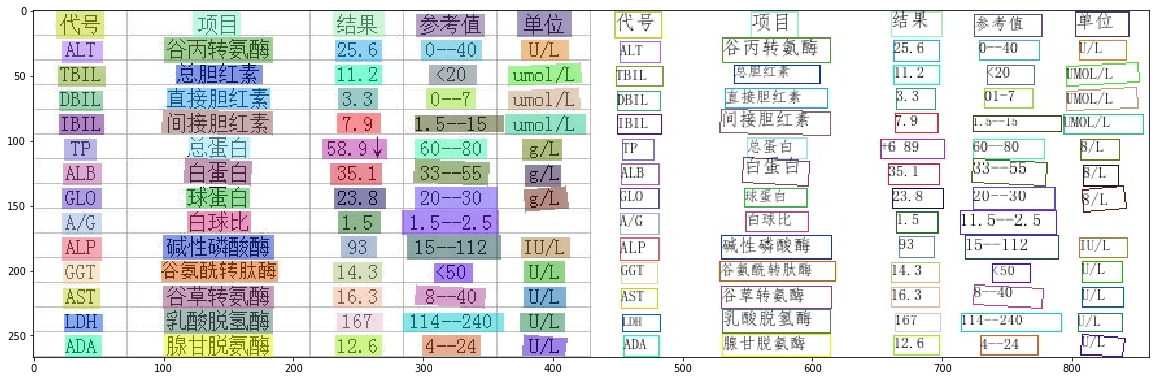

In [13]:
# Use the direction classifier to run the PP-OCRv2 system
!python tools/infer/predict_system.py \
    --image_dir="./doc/imgs/00018069.jpg" \
    --det_model_dir="./inference/ch_PP-OCRv2_det_infer/" \
    --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer/" \
    --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer/" \
    --use_angle_cls=True

# Visualization
img = cv2.imread("./inference_results/00018069.jpg")
plt.figure(figsize=(20, 8))
plt.imshow(img[..., ::-1])
plt.show()

The visual recognition results are saved in the `./inference_results` folder by default.

The detection frame and recognition result are visualized in the image, and the specific recognition file and file reading path information are also printed in the above notebook.
  
If you want to save the cropped recognition results, you can set the `save_crop_res` parameter to True, and the final result is saved in the `output` directory. Some of the cropped images are shown below. The saved results can be used for subsequent labeling and training of recognition models.

[2021/12/22 00:23:26] root DEBUG: dt_boxes num : 69, elapse : 1.6756877899169922
[2021/12/22 00:23:26] root DEBUG: cls num  : 69, elapse : 0.07216906547546387
[2021/12/22 00:23:26] root DEBUG: rec_res num  : 69, elapse : 0.10237336158752441
[2021/12/22 00:23:26] root DEBUG: 0, ('代号', 0.9509918)
[2021/12/22 00:23:26] root DEBUG: 1, ('项目', 0.98095936)
[2021/12/22 00:23:26] root DEBUG: 2, ('结果', 0.99443346)
[2021/12/22 00:23:26] root DEBUG: 3, ('参考值', 0.99930096)
[2021/12/22 00:23:26] root DEBUG: 4, ('单位', 0.99435925)
[2021/12/22 00:23:26] root DEBUG: 5, ('谷丙转氨酶', 0.9817702)
[2021/12/22 00:23:26] root DEBUG: 6, ('25.6', 0.9356477)
[2021/12/22 00:23:26] root DEBUG: 7, ('0--40', 0.99340856)
[2021/12/22 00:23:26] root DEBUG: 8, ('ALT', 0.9987676)
[2021/12/22 00:23:26] root DEBUG: 9, ('U/L', 0.96127224)
[2021/12/22 00:23:26] root DEBUG: 10, ('总胆红素', 0.9696524)
[2021/12/22 00:23:26] root DEBUG: 11, ('11.2', 0.98009694)
[2021/12/22 00:23:26] root DEBUG: 12, ('TBIL', 0.9866674)
[2021/12/22 00:23

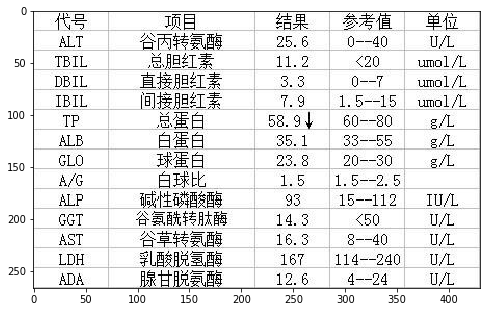

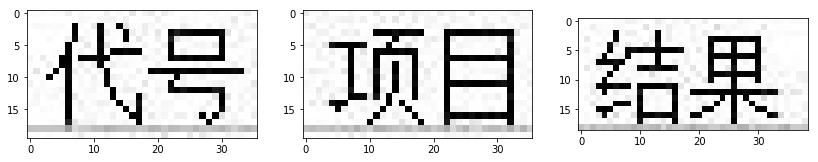

In [15]:
# Crop the result image of text detection and save it
!python tools/infer/predict_system.py \
    --image_dir="./doc/imgs/00018069.jpg" \
    --det_model_dir="./inference/ch_PP-OCRv2_det_infer/" \
    --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer/" \
    --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer/" \
    --use_angle_cls=True \
    --save_crop_res=True

!ls output

plt.figure(figsize=(8, 8))
plt.imshow(cv2.imread("./doc/imgs/00018069.jpg")[:, :, ::-1])
plt.show()
plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plt.imshow(cv2.imread("output/mg_crop_0.jpg")[:, :, ::-1])
plt.subplot(1,3,2)
plt.imshow(cv2.imread("output/mg_crop_1.jpg")[:, :, ::-1])
plt.subplot(1,3,3)
plt.imshow(cv2.imread("output/mg_crop_2.jpg")[:, :, ::-1])
plt.show()

The series prediction is implemented by the `TextSystem` class, and its specific implementation process and function are defined as follows.

[2021/12/22 00:23:29] root DEBUG: dt_boxes num : 69, elapse : 0.04321765899658203
[2021/12/22 00:23:29] root DEBUG: cls num  : 69, elapse : 0.04562950134277344
[2021/12/22 00:23:29] root DEBUG: rec_res num  : 69, elapse : 0.09602046012878418
[2021/12/22 00:23:29] root DEBUG: 0  Predict time of ./doc/imgs/00018069.jpg: 0.195s
[2021/12/22 00:23:29] root DEBUG: 代号, 0.951
[2021/12/22 00:23:29] root DEBUG: 项目, 0.981
[2021/12/22 00:23:29] root DEBUG: 结果, 0.994
[2021/12/22 00:23:29] root DEBUG: 参考值, 0.999
[2021/12/22 00:23:29] root DEBUG: 单位, 0.994
[2021/12/22 00:23:29] root DEBUG: 谷丙转氨酶, 0.982
[2021/12/22 00:23:29] root DEBUG: 25.6, 0.936
[2021/12/22 00:23:29] root DEBUG: 0--40, 0.993
[2021/12/22 00:23:29] root DEBUG: ALT, 0.999
[2021/12/22 00:23:29] root DEBUG: U/L, 0.961
[2021/12/22 00:23:29] root DEBUG: 总胆红素, 0.970
[2021/12/22 00:23:29] root DEBUG: 11.2, 0.980
[2021/12/22 00:23:29] root DEBUG: TBIL, 0.987
[2021/12/22 00:23:29] root DEBUG: <20, 0.976
[2021/12/22 00:23:29] root DEBUG: UMOL/

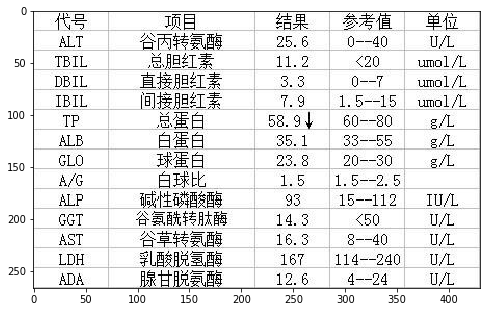

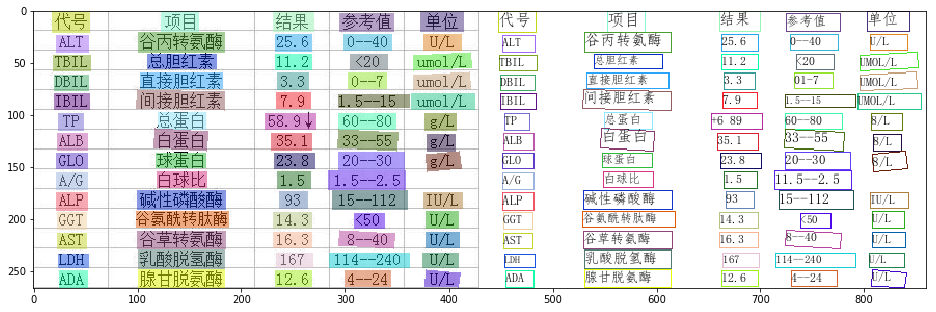

In [16]:
# Reference Code：https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/tools/infer/predict_system.py
from tools.infer.utility import draw_ocr_box_txt, get_rotate_crop_image
from ppocr.utils.utility import get_image_file_list

class TextSystem(object):
    # Initialization function
    def __init__(self, args):
        self.args = args
        # If you do not want to display log, you can set show_log to False
        if not args.show_log:
            logger.setLevel(logging.INFO)
        # Define text recognition model prediction engine
        self.text_detector = TextDetector(args)
        # Define text recognition model prediction engine
        self.text_recognizer = TextRecognizer(args)
        # Whether to use direction classifier
        self.use_angle_cls = args.use_angle_cls
        # Score threshold, according to the threshold to determine whether the detection and recognition results need to be visualized or returned
        self.drop_score = args.drop_score
        # Define the direction classifier prediction engine
        if self.use_angle_cls:
            self.text_classifier = TextClassifier(args)

    # Save text detection result image
    def draw_crop_rec_res(self, output_dir, img_crop_list, rec_res):
        os.makedirs(output_dir, exist_ok=True)
        bbox_num = len(img_crop_list)
        for bno in range(bbox_num):
            cv2.imwrite(
                os.path.join(output_dir,
                             f"mg_crop_{bno+self.crop_image_res_index}.jpg"),
                img_crop_list[bno])
            logger.debug(f"{bno}, {rec_res[bno]}")
        self.crop_image_res_index += bbox_num
    
    # Core prediction function
    def __call__(self, img, cls=True):
        ori_im = img.copy()
        # Get the detection result of the detection text
        dt_boxes, elapse = self.text_detector(img)
        logger.debug("dt_boxes num : {}, elapse : {}".format(
            len(dt_boxes), elapse))
        if dt_boxes is None:
            return None, None
        img_crop_list = []
        # Sort the detection boxes, the order is: first from top to bottom, and second from left to right
        dt_boxes = sorted_boxes(dt_boxes)
        # Perform perspective transformation and correction on detection results
        for bno in range(len(dt_boxes)):
            tmp_box = copy.deepcopy(dt_boxes[bno])
            img_crop = get_rotate_crop_image(ori_im, tmp_box)
            img_crop_list.append(img_crop)
        # Use the direction classifier to correct the detection result
        if self.use_angle_cls and cls:
            img_crop_list, angle_list, elapse = self.text_classifier(
                img_crop_list)
            logger.debug("cls num  : {}, elapse : {}".format(
                len(img_crop_list), elapse))
        # Get text recognition results
        rec_res, elapse = self.text_recognizer(img_crop_list)
        logger.debug("rec_res num  : {}, elapse : {}".format(
            len(rec_res), elapse))
        # Save the corrected text detection image
        if self.args.save_crop_res:
            self.draw_crop_rec_res(self.args.crop_res_save_dir, img_crop_list,
                                   rec_res)
        filter_boxes, filter_rec_res = [], []
        #Filter the results according to the threshold of the recognition score, if the score is less than the threshold, filter out
        for box, rec_reuslt in zip(dt_boxes, rec_res):
            text, score = rec_reuslt
            if score >= self.drop_score:
                filter_boxes.append(box)
                filter_rec_res.append(rec_reuslt)
        return filter_boxes, filter_rec_res

def sorted_boxes(dt_boxes):
    # Sort the detection boxes: first from top to bottom, then from left to right
    num_boxes = dt_boxes.shape[0]
    sorted_boxes = sorted(dt_boxes, key=lambda x: (x[0][1], x[0][0]))
    _boxes = list(sorted_boxes)

    for i in range(num_boxes - 1):
        if abs(_boxes[i + 1][0][1] - _boxes[i][0][1]) < 10 and \
                (_boxes[i + 1][0][0] < _boxes[i][0][0]):
            tmp = _boxes[i]
            _boxes[i] = _boxes[i + 1]
            _boxes[i + 1] = tmp
    return _boxes

args = parse_args()
args.cls_model_dir = "./inference/ch_ppocr_mobile_v2.0_cls_infer"
args.det_model_dir="./inference/ch_PP-OCRv2_det_infer/"
args.rec_model_dir="./inference/ch_PP-OCRv2_rec_infer/"
args.image_dir = "./doc/imgs/00018069.jpg"
args.use_angle_cls=True
args.use_gpu=True

image_file_list = get_image_file_list(args.image_dir)
image_file_list = image_file_list[args.process_id::args.total_process_num]
text_sys = TextSystem(args)
is_visualize = True
font_path = args.vis_font_path
drop_score = args.drop_score

total_time = 0
cpu_mem, gpu_mem, gpu_util = 0, 0, 0
_st = time.time()
count = 0
for idx, image_file in enumerate(image_file_list):
    img = cv2.imread(image_file)
    if img is None:
        logger.debug("error in loading image:{}".format(image_file))
        continue
    starttime = time.time()
    dt_boxes, rec_res = text_sys(img)
    elapse = time.time() - starttime
    total_time += elapse

    logger.debug(
        str(idx) + "  Predict time of %s: %.3fs" % (image_file, elapse))
    for text, score in rec_res:
        logger.debug("{}, {:.3f}".format(text, score))

    if is_visualize:
        image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        boxes = dt_boxes
        txts = [rec_res[i][0] for i in range(len(rec_res))]
        scores = [rec_res[i][1] for i in range(len(rec_res))]

        draw_img = draw_ocr_box_txt(
            image,
            boxes,
            txts,
            scores,
            drop_score=drop_score,
            font_path=font_path)
        draw_img_save_dir = args.draw_img_save_dir
        os.makedirs(draw_img_save_dir, exist_ok=True)
        cv2.imwrite(
            os.path.join(draw_img_save_dir, os.path.basename(image_file)),
            draw_img[:, :, ::-1])
        logger.debug("The visualized image saved in {}".format(
            os.path.join(draw_img_save_dir, os.path.basename(image_file))))

logger.info("The predict total time is {}".format(time.time() - _st))

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()
plt.figure(figsize=(16, 8))
plt.imshow(draw_img)
plt.show()


## 2.6 PP-OCRv2 - Use whl Package for Prediction and Inference

In order to more conveniently and quickly experience the OCR text detection and recognition model, PaddleOCR provides a whl package based on the Paddle Inference prediction engine, which is convenient for you to install and experience PaddleOCR with one click.

### 2.6.1 Install whl Package

Use pip to install the whl package of paddleocr, the command is as follows.

In [14]:
!pip install "paddleocr==2.3.0.2"

# If you want to get the latest features, you can compile and install based on the source code
#     python3 setup.py bdist_wheel
#     pip3 install dist/paddleocr-x.x.x-py3-none-any.whl # x.x.x Is the version number of paddleocr


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 250 kB 13.6 MB/s            


### 2.6.2 Use whl Package Predictive Inference

The paddleocr whl package will automatically download the PP-OCRv2 ultra-lightweight model as the default model. It also supports custom model paths, prediction configurations and other parameters. The parameter names are the same as those in the Python prediction based on Paddle Inference.


* Perform Testing Separately

Run the following code to quickly experience the prediction and effect of the text detection model.

[2021/12/25 16:04:56] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
download https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar to /home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer/ch_PP-OCRv2_det_infer.tar
download https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar to /home/aistudio/.paddleocr/2.3.0.2/ocr/rec/ch/ch_PP-OCRv2_rec_infer/ch_PP-OCRv2_rec_infer.tar


100%|██████████| 3.19M/3.19M [00:00<00:00, 47.1MiB/s]
100%|██████████| 8.88M/8.88M [00:00<00:00, 54.8MiB/s]
100%|██████████| 1.45M/1.45M [00:00<00:00, 35.4MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e

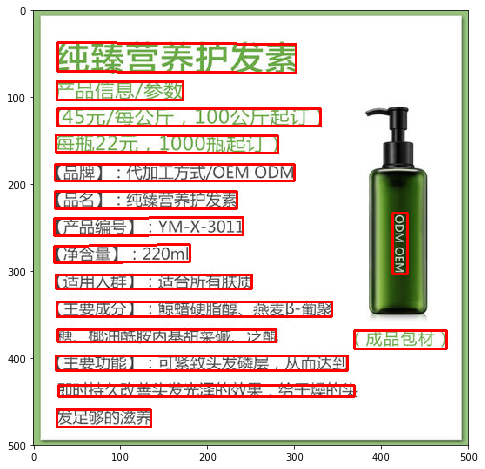

In [15]:
from paddleocr import PaddleOCR, draw_ocr

ocr = PaddleOCR(use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs/11.jpg'
result = ocr.ocr(img_path, rec=False)
for line in result:
    print(line)

# show result
from PIL import Image

image = Image.open(img_path).convert('RGB')
im_show = draw_ocr(image, result, txts=None, scores=None, font_path='/home/aistudio/PaddleOCR/doc/fonts/simfang.ttf')
plt.figure(figsize=(15, 8))
plt.imshow(im_show)
plt.show()

* Perform identification separately

You can specify `det=False` to run only a single recognition module.

In [16]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs_words/ch/word_1.jpg'
result = ocr.ocr(img_path, det=False)
for line in result:
    print(line)

[2021/12/25 16:05:03] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, 

* Separately execute the direction classifier

You can specify `det=False, rec=False, cls=True` to run only the direction classifier.

[2021/12/25 16:06:27] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, 

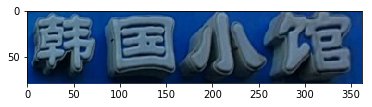

In [21]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs_words/ch/word_1.jpg'
result = ocr.ocr(img_path, det=False, rec=False, cls=True)
for line in result:
    print(line)

img = cv2.imread(img_path)
plt.imshow(img[...,::-1])
plt.show()


*`Detection + direction classifier + recognition` whole process experience


[2021/12/25 16:07:58] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, 

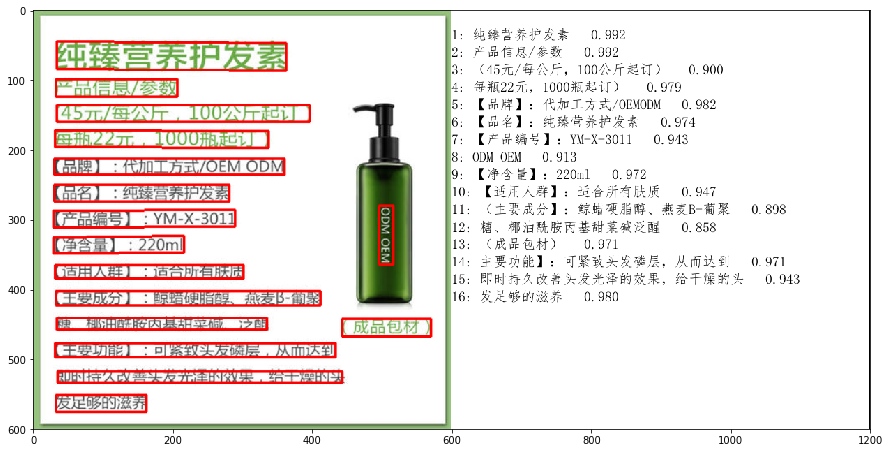

In [22]:
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
%matplotlib inline

# PaddleOCRCurrently supports Chinese and English, English, French, German, Korean, Japanese, and can be switched by modifying the lang parameter
# The parameters are `ch`, `en`, `french`, `german`, `korean`, `japan`.
ocr = PaddleOCR(use_angle_cls=True, lang="ch", use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs/11.jpg'
result = ocr.ocr(img_path, cls=True)
for line in result:
    print(line)

# show result
from PIL import Image

image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='/home/aistudio/PaddleOCR/doc/fonts/simfang.ttf')
plt.figure(figsize=(15, 8))
plt.imshow(im_show)
plt.show()

The result is a list, each item contains a text box, text and recognition confidence.

# 3 C++ Inference Based on Paddle Inference

In the inference deployment process, the performance of C++ is generally better than that of Python. Therefore, in many actual inference scenarios, C++ will be considered as a development language for inference.

The Paddle Inference introduced to you in the previous section also supports the C++ inference process. This section mainly introduces the C++ PP-OCRv2 inference process.

When using C++ inference on the PP-OCRv2 system based on Paddle Inference, there are the following steps.

(1) Prepare the model

(2) Compile the opencv library

(3) Get Paddle Inference prediction library

(4) Compile PaddleOCR C++ inference code

(5) Run PP-OCRv2 system

Due to the limitation of the version on AiStudio, the specific demonstration process will not be done here, only the specific process will be introduced to you. It is recommended that you experience the C++ inference process of PP-OCRv2 locally.

For more detailed content in this section, please refer to: [PP-OCRv2 C++ Inference Tutorial](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/deploy/cpp_infer/readme.md).

## 3.1 Preparing the Model

Use the following command to prepare the inference model of PP-OCRv2.

```bash
cd deploy/cpp_infer
wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar
wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar &&  tar -xf ch_PP-OCRv2_rec_infer.tar
wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O ch_ppocr_mobile_v2.0_cls_infer.tar && tar -xf ch_ppocr_mobile_v2.0_cls_infer.tar
```

## 3.2 Compile OpenCV Library

* First, you need to download the package compiled in the Linux environment from the opencv official website. Take opencv 3.4.7 as an example. The download command is as follows.

```bash
wget https://paddleocr.bj.bcebos.com/libs/opencv/opencv-3.4.7.tar.gz
tar -xf opencv-3.4.7.tar.gz
```

Finally, you can see the folder `opencv-3.4.7/` in the current directory.

* Compile OpenCV, set OpenCV source path (`root_path`) and installation path (`install_path`). Enter the opencv source code path and compile in the following way.

```shell
root_path="your_opencv_root_path"
install_path=${root_path}/opencv3
build_dir=${root_path}/build

rm -rf ${build_dir}
mkdir ${build_dir}
cd ${build_dir}

cmake .. \
    -DCMAKE_INSTALL_PREFIX=${install_path} \
    -DCMAKE_BUILD_TYPE=Release \
    -DBUILD_SHARED_LIBS=OFF \
    -DWITH_IPP=OFF \
    -DBUILD_IPP_IW=OFF \
    -DWITH_LAPACK=OFF \
    -DWITH_EIGEN=OFF \
    -DCMAKE_INSTALL_LIBDIR=lib64 \
    -DWITH_ZLIB=ON \
    -DBUILD_ZLIB=ON \
    -DWITH_JPEG=ON \
    -DBUILD_JPEG=ON \
    -DWITH_PNG=ON \
    -DBUILD_PNG=ON \
    -DWITH_TIFF=ON \
    -DBUILD_TIFF=ON

make -j
make install
```

You can also directly modify the content of `tools/build_opencv.sh`, and then directly run the following command to compile.
```shell
sh tools/build_opencv.sh
```

Among them, `root_path` is the downloaded opencv source code path, `install_path` is the opencv installation path, after the completion of `make install`, opencv header files and library files will be generated in this folder for OCR code compilation later.

The final file structure under the installation path is shown below.
```
opencv3/
|-- bin
|-- include
|-- lib
|-- lib64
|-- share
```

## 3.3 Get **Paddle Inference** Prediction Library

* The Linux prediction library of different cuda versions is provided on [Paddle Inference library official website](https://paddle-inference.readthedocs.io/en/latest/user_guides/download_lib.html). You can choose the appropriate prediction library version according to your own environment on the official website.

* After downloading, use the following method to decompress.

```bash
wget https://paddle-inference-lib.bj.bcebos.com/2.2.1/cxx_c/Linux/GPU/x86-64_gcc8.2_avx_mkl_cuda10.2_cudnn8.1.1_trt7.2.3.4/paddle_inference.tgz -O paddle_inference.tgz
tar -xf paddle_inference.tgz
```

Finally, a subfolder of `paddle_inference/` will be generated in the current folder.

## 3.4 Compile the Inference Code of PaddleOCR

The compilation command is as follows, among which the addresses of other dependent libraries such as Paddle C++ prediction library and opencv need to be replaced with the actual addresses on your own machine.
```shell
sh tools/build.sh
```
* Specifically, you need to modify the environment path in `tools/build.sh`, the relevant content is as follows:

```shell
OPENCV_DIR=your_opencv_dir
LIB_DIR=your_paddle_inference_dir
CUDA_LIB_DIR=your_cuda_lib_dir
CUDNN_LIB_DIR=/your_cudnn_lib_dir
```

Among them, `OPENCV_DIR` is the address where opencv is compiled and installed; `LIB_DIR` is the download (`paddle_inference` folder) or compiled Paddle prediction library address (`build/paddle_inference_install_dir` folder); `CUDA_LIB_DIR` is the cuda library file address , In docker it is `/usr/local/cuda/lib64`; `CUDNN_LIB_DIR` is the cudnn library file address, in docker it is `/usr/lib/x86_64-linux-gnu/`. **Note: The above paths are written as absolute paths, do not write relative paths.**

* After the compilation is complete, an executable file named `ppocr` will be generated in the `build` folder.

## 3.5 Run PP-OCRv2 System

Operation mode：  
```shell
./build/ppocr <mode> [--param1] [--param2] [...]
```
Among them, `mode` is a required parameter, which means the selected function, and the value range is ['det','rec','system'], which respectively means calling detection, recognition, and detection and recognition series (including direction classifier). The specific commands are as follows:

*Run text detection model only

```shell
./build/ppocr det \
    --det_model_dir=./ch_PP-OCRv2_det_infer/ \
    --image_dir=../../doc/imgs/12.jpg
```
* Run text detection model only

```shell
./build/ppocr rec \
    --rec_model_dir=./ch_PP-OCRv2_rec_infer/ \
    --image_dir=../../doc/imgs_words/ch/
```
* Run PP-OCRv2 system

```shell
# Do not use direction classifier
./build/ppocr system \
    --det_model_dir=./ch_PP-OCRv2_det_infer/ \
    --rec_model_dir=./ch_PP-OCRv2_rec_infer/ \
    --image_dir=../../doc/imgs/12.jpg

#  use direction classifier
./build/ppocr system \
    --det_model_dir=./ch_PP-OCRv2_det_infer/ \
    --rec_model_dir=./ch_PP-OCRv2_rec_infer/ \
    --use_angle_cls=true \
    --cls_model_dir=./ch_ppocr_mobile_v2.0_cls_infer \
    --image_dir=../../doc/imgs/12.jpg
```

# 4 **Paddle Serving** Service Deployment Practice

In Sections 2 and 3, we introduced in detail the PP-OCRv2 system inference based on Paddle Inference, which belongs to offline inference, that is, the code deployed on a specific machine can only be used on this machine and cannot be passed through other machines. Make a visit. Therefore, the demand for model service deployment is derived.

Service-oriented deployment refers to deploying the model as a service, and other devices can access the service by sending a request to obtain the inference result of the model service. The service deployment diagram is shown below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/831abb70838e456fb2cec236817b9c5b1a0dff15fff7479e8f8430493c4506ea"  width = "400" />
</div>
<center>Figure 4: Schematic diagram of service deployment</center>

After the model is successfully deployed, different users can obtain inference services by sending network requests through the client.

Paddle Serving is a tool created by Flying Paddle to facilitate developers' service deployment. This section mainly introduces the service deployment process of PP-OCRv2 system based on Paddle Serving.

## 4.1 Paddle Serving Introduction

Paddle Serving is an open source service deployment framework for PaddlePaddle. Its long-term goal is to provide more and more professional, reliable, and easy-to-use services around the last mile of artificial intelligence landing. Paddle Serving currently provides two frameworks, C++ Serving and Python Pipeline. The Python Pipeline framework tends to facilitate the secondary development, and the C++ Serving framework tends to pursue the ultimate performance.

When the PP-OCRv2 model is deployed as a service based on Paddle Serving, the process is as follows.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/348c446f79a04bca8801b5fc6dd3c5d5207711179d4d4d9db15e8cb4b1bd8810"  width = "800" />
</div>
<center>Figure 5: Flow chart of PP-OCRv2 system deployment based on Paddle Serving</center>


## 4.2 Prepare Inference Data and Deployment Environment

The data is consistent with the data used for model inference.

To run Paddle Serving, three installation packages of Paddle Serving need to be installed: paddle-serving-server, paddle-serving-client and paddle-serving-app. The commands are as follows.

In [23]:
!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl
!pip install paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl

!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_client-0.7.0-cp37-none-any.whl
!pip install paddle_serving_client-0.7.0-cp37-none-any.whl

!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_app-0.7.0-py3-none-any.whl
!pip install paddle_serving_app-0.7.0-py3-none-any.whl

!rm ./*.whl

--2021-12-25 16:25:12--  https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl
Resolving paddle-serving.bj.bcebos.com (paddle-serving.bj.bcebos.com)... 100.67.200.6
Connecting to paddle-serving.bj.bcebos.com (paddle-serving.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7146257 (6.8M) [application/octet-stream]
Saving to: ‘paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl’

paddle_serving_serv 100%[===================>]   6.81M  --.-KB/s    in 0.1s    

2021-12-25 16:25:12 (57.6 MB/s) - ‘paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl’ saved [7146257/7146257]

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Processing ./paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl
     |████████████████████████████████| 125 kB 14.9 MB/s            
     |████████████████████████████████| 44 kB 6.3 MB/s             
  Preparing metadata (setup.py) ... done


## 4.3 Preparing to deploy the model

When deploying a model as a service, the inference model needs to be transformed into a model for user service deployment.

First run the following command to download the inference model.


In [24]:
os.chdir("/home/aistudio/PaddleOCR/deploy/pdserving/")

# Download and unzip the OCR text detection model
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar && rm ch_PP-OCRv2_det_infer.tar
# Download and unzip the OCR text detection model
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar &&  tar -xf ch_PP-OCRv2_rec_infer.tar && rm ch_PP-OCRv2_rec_infer.tar

--2021-12-25 16:25:32--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190272 (3.0M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_infer.tar’

ch_PP-OCRv2_det_inf 100%[===================>]   3.04M  --.-KB/s    in 0.09s   

2021-12-25 16:25:32 (35.0 MB/s) - ‘ch_PP-OCRv2_det_infer.tar’ saved [3190272/3190272]

--2021-12-25 16:25:33--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8875520 (8.5M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_rec_infer.tar’

ch_PP-OCRv2_rec_inf 100%[===

Run the following command to convert the model.


In [25]:
# Conversion detection model
!python -m paddle_serving_client.convert --dirname ./ch_PP-OCRv2_det_infer/ \
                                         --model_filename inference.pdmodel          \
                                         --params_filename inference.pdiparams       \
                                         --serving_server ./ppocrv2_det_serving/ \
                                         --serving_client ./ppocrv2_det_client/

# Conversion recognition model
!python -m paddle_serving_client.convert --dirname ./ch_PP-OCRv2_rec_infer/ \
                                         --model_filename inference.pdmodel          \
                                         --params_filename inference.pdiparams       \
                                         --serving_server ./ppocrv2_rec_serving/  \
                                         --serving_client ./ppocrv2_rec_client/

# View folder
!tree -h *_client *_serving

ppocrv2_det_client
├── [ 296]  serving_client_conf.prototxt
└── [  98]  serving_client_conf.stream.prototxt
ppocrv2_rec_client
├── [ 284]  serving_client_conf.prototxt
└── [  93]  serving_client_conf.stream.prototxt
ppocrv2_det_serving
├── [2.2M]  inference.pdiparams
├── [842K]  inference.pdmodel
├── [ 296]  serving_server_conf.prototxt
└── [  98]  serving_server_conf.stream.prototxt
ppocrv2_rec_serving
├── [7.9M]  inference.pdiparams
├── [527K]  inference.pdmodel
├── [ 284]  serving_server_conf.prototxt
└── [  93]  serving_server_conf.stream.prototxt

0 directories, 12 files


After the detection model is converted, there will be additional folders of `ppocrv2_det_mobile_serving` and `ppocrv2_det_mobile_client` in the current folder, with the following format:

```
|- ppocrv2_det_mobile_serving/
  |- __model__  
  |- __params__
  |- serving_server_conf.prototxt  
  |- serving_server_conf.stream.prototxt

|- ppocrv2_det_mobile_client
  |- serving_client_conf.prototxt  
  |- serving_client_conf.stream.prototxt

```

The recognition model is the same.
## 4.4 Paddle Serving pipeline deployment

**Note**: Modify the two `model_config` fields in the PaddleOCR/deploy/pdserving/config.yml file to ppocrv2_det_mobile_serving and ppocrv2_rec_mobile_serving, corresponding to the folder for model conversion.

     The pdserving directory contains the code to start the pipeline service and send prediction requests, including:
    ```
    __init__.py
    config.yml            # Start the service configuration file
    ocr_reader.py         # OCR model pre-processing and post-processing code implementation
    pipeline_http_client.py   # Script to send prediction request
    web_service.py        # Start the server-side script
    ```

### 4.4.1 Start the service

Run the following command to start the service:

**Open a new terminal and run the following command to start the service**

    ```
    # Start the service and save the running log inweb_serving_log.txt
    cd PaddleOCR/deploy/pdserving/
    nohup python web_service.py &>web_serving_log.txt &
    ```
After the service is successfully started, a log similar to the following will be printed in web_serving_log.txt
<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/58b32c0158f34a739f9d4b5246b68575519543c786044c19849ab43246f1b482"  width = "800" />
</div>
<center>Figure 6: Server log</center>


### 4.4.2 Send service request:

In [26]:
!python pipeline_http_client.py

{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['土地整治与土壤修复研究中心', '华南农业大学|东图']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['纯臻营养护发素', '产品信息/参数', '（45元/每公斤，100公斤起订', '每瓶22元，1000瓶起订）', '【品牌】：代加工方式/OEMODM', '【品名】：纯臻营养护发素', '【产品编号】：YM-X-3011', 'ODMOEM', '（净含量】：220ml', '【适用人群）：适合所有肤质', '［主要成分】：鲸蜡硬脂醇、燕麦B-葡聚', '糖、椰油酰胺内基甜菜碱、泛醒', '（成品包材）', '主要功能】：可紧致头发磷层，从而达到', '即时持久改善头发光泽的效果，给干燥的头', '发足够的滋养']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['Mairiedu|er|农', '*|Palais du LOUVRE', '公 LES ARTS DECORATIFS', '＊ Musée du LOUVRE', 'Theatre', 'du PALAIS-ROYAL L&']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['2', '证#', '', '##', '孔叫叫E2号动']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['合格证', '品名：纯棉单面背心套', '执行标准：FZ/T73025-2006', '安全类别：GB18401-2010', 'A类婴幼儿用品', '货号：B2390', 'DREA', '等级：一等品检验员：08', 'WOTHERAL', '成份：面料：100%棉', '小晶晶母婴', '品名：纯棉单面背心套', '上装：66/48', '零售价：47.50元', '下装：66/47'

You can further adjust the number of concurrency in config.yml, here only the run-through effect is demonstrated, and it is set to 1 by default here

```
    det:
        #Concurrency, when is_thread_op=True, it is thread concurrency; otherwise, it is process concurrency
        concurrency: 1
        ...
    rec:
        #Concurrency, when is_thread_op=True, it is thread concurrency; otherwise, it is process concurrency
        concurrency: 1
        ...
```

The predicted performance data will be automatically written into the `PipelineServingLogs/pipeline.tracer` file.



## 4.5 FAQ

**Q1**: After sending the request, there is no result returned or the output decoding error is prompted

**A1**: Do not set the proxy when starting the service and sending the request. You can close the proxy before starting the service and before sending the request. The command to close the proxy is:
```
unset https_proxy
unset http_proxy
```

# 5. Practical end-to-side inference based on Paddle Lite

With the popularity of the mobile Internet at any time, more and more mobile phones and embedded devices are used. At the same time, considering data security and model operating costs, more and more models are directly run in end-side devices.

Paddle Lite is a lightweight inference engine for flying paddles. It provides efficient inference capabilities for mobile phones and IOT terminals, and extensively integrates cross-platform hardware to provide lightweight deployment solutions for end-side deployment and application landing issues.

The introduction in this chapter is based on [Paddle Lite](https://github.com/PaddlePaddle/Paddle-Lite) Steps to deploy PaddleOCR ultra-lightweight Chinese detection and recognition model on the mobile terminal.


Let me show you the demo of the PP-OCRv2 series model running on Android.

[Android demo demo link](https://paddleocr.bj.bcebos.com/presentation_demo/android_lite%20demo.mp4)

Since it is not possible to demonstrate here, here is how to develop the PP-OCRv2 system running program based on Paddle Lite.

If you want practical operation, you can refer to [PaddleOCR deployment document based on Paddle Lite](https://github.com/PaddlePaddle/PaddleOCR/blob/dygraph/deploy/lite/readme.md).

## 5.1 Prepare the environment

Here you need to prepare the cross-compilation environment and the Paddle Lite prediction library at the same time. The cross-compilation environment is used to generate executable files that can be used on end-side devices. It is recommended to use docker as a cross-compilation environment.

## 5.2 Preparing the model

When using Paddle Lite for model prediction, it is necessary to first convert the inference model into an optimized model for Paddle Lite prediction (the suffix is generally `nb`). It adopts a variety of strategies to automatically optimize the original model, including quantification, Methods such as subgraph fusion, hybrid scheduling, and Kernel optimization. The optimized model is lighter and faster.

## 5.3 Compile

Run `make -j` to execute the compilation and get the executable file. The first execution of this command will download dependent libraries such as opencv. After the download is complete, run `make -j` again.

## 5.4 Upload to mobile terminals such as mobile phones

Use tools such as adb to transfer executable files, model files, configuration files, etc. to mobile terminals such as mobile phones.

## 5.5 Run

Run the executable file on the mobile terminal to get the result, and the output example is as follows.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/c05a80380a6d483b81dd1be87f78beb4ec67659eabc7454686ea9588ea46c3ab"  width = "600" />
</div>
<center>Figure 7: Mobile terminal output result</center>

## 5.6 FAQ

Q1: What if I want to change the model, do I need to go through the process again?

A1: If you have gone through the above steps, you only need to replace the .nb model file to replace the model. At the same time, pay attention to updating the dictionary

Q2: How to test with another picture?

A2: Replace the .jpg test image under debug with the image you want to test, just push adb to the phone

Q3: How to package it into the mobile APP?

A3: This demo aims to provide the core algorithm part that can run OCR on mobile phones. PaddleOCR/deploy/android_demo is an example of encapsulating this demo into a mobile app for reference

# 6. Homework

Please refer to [Predictive Deployment Objective Questions](https://aistudio.baidu.com/aistudio/education/objective/28710) and [Predictive Deployment Practice Questions](https://aistudio.baidu.com/aistudio/projectdetail/3297083) part.